In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

In [172]:
# 前処理
df = pd.read_csv('XRP_JPY.csv', encoding='utf-8')
df = df.drop(["始値", "高値", "安値", "出来高", "変化率 %"], axis=1)
df = df.rename(columns={'終値': 'Close', "日付け": 'Date'})
df.set_index("Date", inplace=True)
df = df.sort_index()
df

,Close
Date,
2018-01-23,152.900
2018-01-24,147.820
2018-01-25,146.000
2018-01-26,126.800
2018-01-27,136.104
...,...
2023-11-30,89.793
2023-12-01,90.054
2023-12-02,91.195


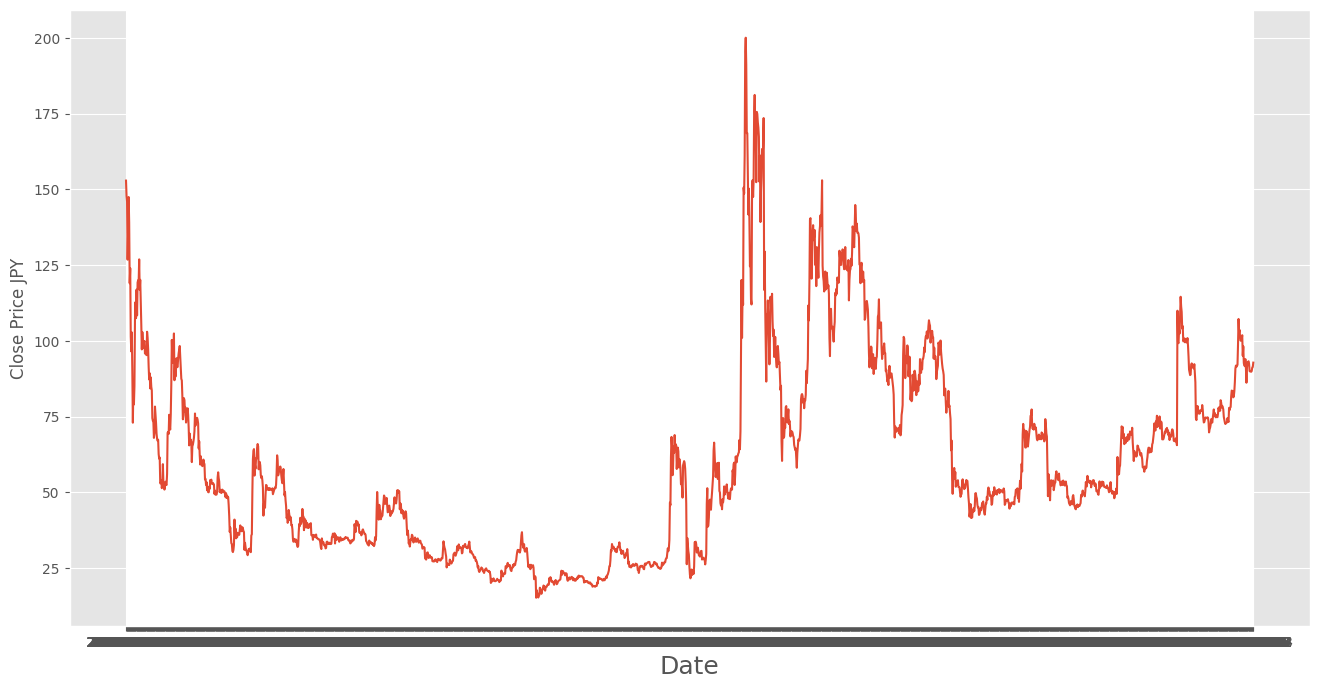

In [173]:
plt.figure(figsize=(16, 8))
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price JPY")
plt.show()

In [174]:
# 正規化
train = df.loc[:"2021-12-31"].values
test = df.loc["2022-01-01":].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)
scaled_train_data = scaler.transform(train)
scaled_test_data = scaler.transform(test)

In [175]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, sequence_size: int) -> Tuple[np.ndarray, np.ndarray]:
    num_data = len(data)
    seq_data = []
    target_data = []
    for i in range(num_data - sequence_size):
        seq_data.append(data[i:i+sequence_size])
        target_data.append(data[i+sequence_size:i+sequence_size+1])
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [176]:
seq_length = 30
train_X, train_Y = make_sequence_data(scaled_train_data, seq_length)
test_X, test_Y = make_sequence_data(scaled_test_data, seq_length)

tensor_train_X = torch.FloatTensor(train_X).permute(1, 0, 2)
tensor_train_Y = torch.FloatTensor(train_Y).permute(1, 0, 2)
tensor_test_X = torch.FloatTensor(test_X).permute(1, 0, 2)

test_Y = test_Y.reshape(len(test_Y), 1)

In [177]:
class LSTM(nn.Module):
    def __init__(self, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)

        return x

In [178]:
model = LSTM(100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [179]:
epochs = 100
losses = []
with tqdm(total=epochs, desc='Training', position=0) as pbar:
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(tensor_train_X)
        loss = criterion(output, tensor_train_Y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        pbar.update()
    

Training:   0%|          | 0/100 [00:00<?, ?it/s]/home/naoya/ai/lstm_virtual_currency_forecast/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1409, 1])) that is different to the input size (torch.Size([1409, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


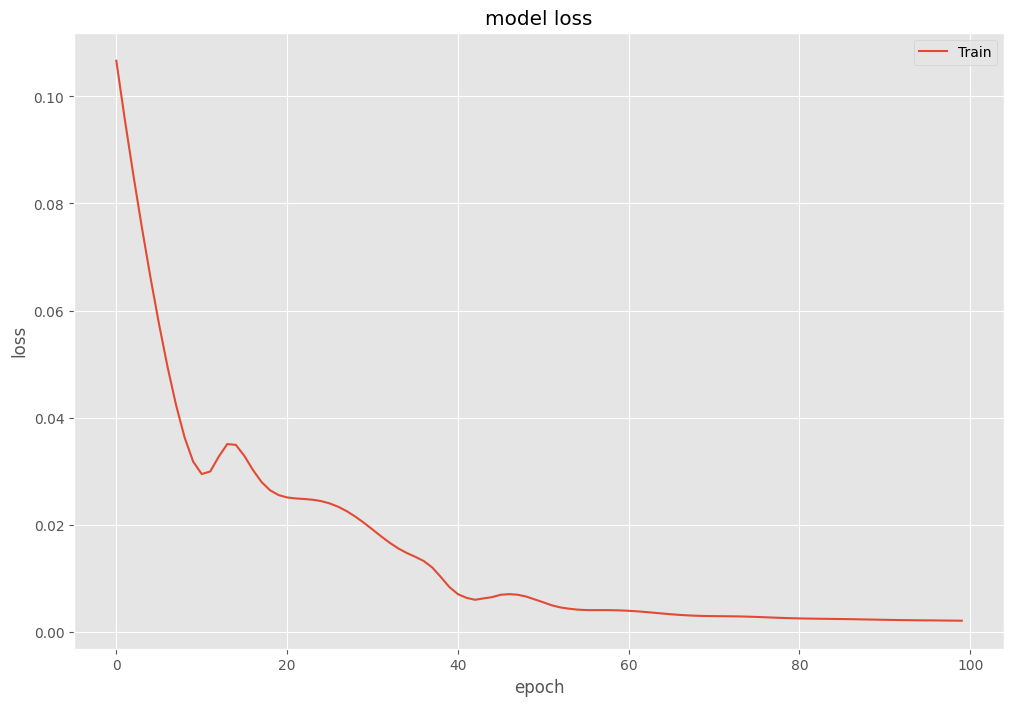

In [180]:
plt.figure(figsize=(12, 8))
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses)
plt.legend(["Train"])
plt.show()

In [181]:
predictions = model(tensor_test_X).detach().numpy()

In [182]:
rmse = mean_squared_error(test_Y, predictions, squared=False)
rmse

0.032639544048187495

/tmp/ipykernel_18439/3256148861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = scaler.inverse_transform(predictions)


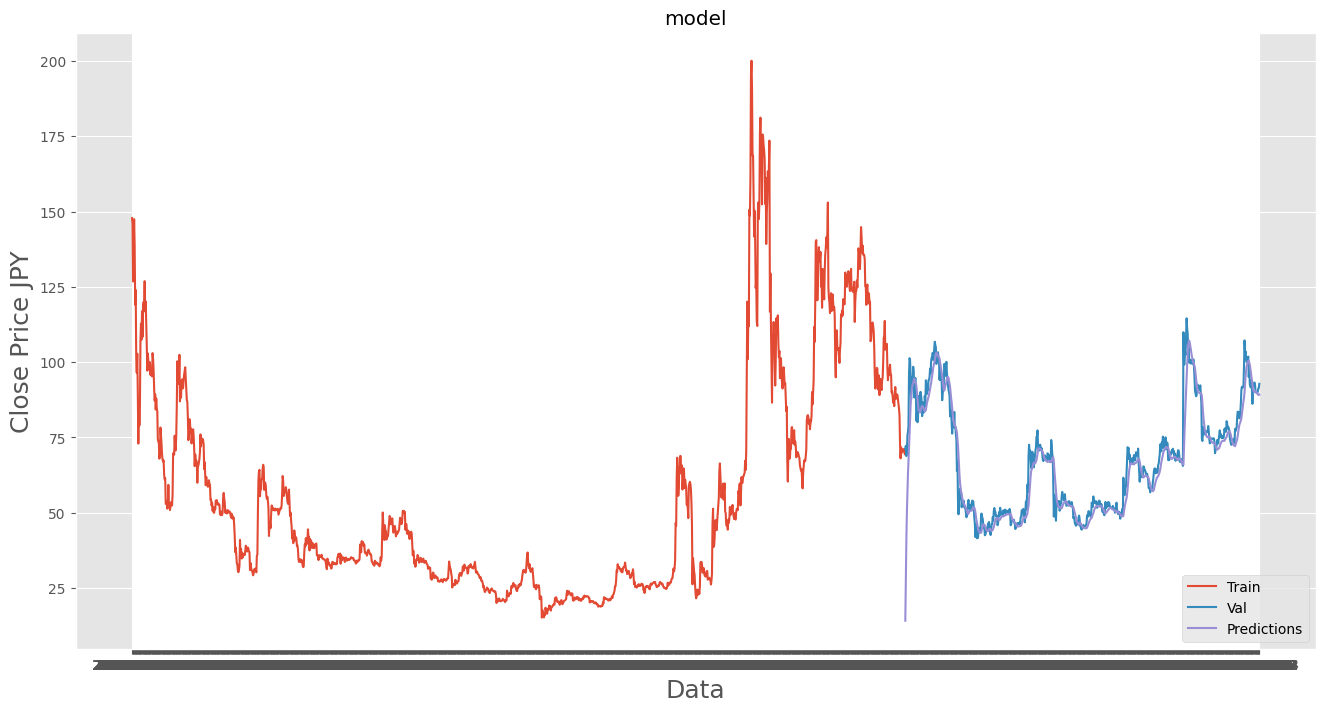

In [183]:
train = df.loc["2018-01-23:":"2022-01-30"]
valid = df.loc["2022-01-31"::]

valid["Predictions"] = scaler.inverse_transform(predictions)

plt.figure(figsize=(16, 8))
plt.title("model")
plt.xlabel("Data", fontsize=18)
plt.ylabel("Close Price JPY", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [185]:
close_data = np.array(df["Close"].values).reshape(len(df["Close"].values), 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
scaled_train_data = scaler.transform(close_data)
train_X, train_Y = make_sequence_data(scaled_train_data, seq_length)
tensor_train_X = torch.FloatTensor(train_X).permute(1, 0, 2)
tensor_train_Y = torch.FloatTensor(train_Y).permute(1, 0, 2)


In [186]:
model = LSTM(100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [204]:
epochs = 100
losses = []
with tqdm(total=epochs, desc='Training', position=0) as pbar:
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(tensor_train_X)
        loss = criterion(output, tensor_train_Y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        pbar.update()

Training:   0%|          | 0/100 [00:00<?, ?it/s]/home/naoya/ai/lstm_virtual_currency_forecast/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2112, 1])) that is different to the input size (torch.Size([2112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


In [215]:
def get_future_data(model: LSTM, scaled_data: np.ndarray, seq_size: int, num_predict_data: int) -> np.ndarray:
    for num in range(num_predict_data):
        seq = torch.FloatTensor(scaled_data[-seq_size:])
        if num == 0:
            seq = seq.unsqueeze(dim=-1)
        else:
            seq = seq.unsqueeze(dim=-1)
            seq = seq.unsqueeze(dim=-1)
        prediction = model(seq)
        scaled_data = np.append(scaled_data, prediction.detach().numpy())
        predicted_data = scaler.inverse_transform(prediction.detach().numpy())

    predicted_data = scaler.inverse_transform(scaled_data[-num_predict_data:].reshape(1, -1))

    return predicted_data

In [220]:
predict_date = 30

predicted_data = get_future_data(model, scaled_train_data, 30, predict_date)
predicted_data

array([[36.91365954, 30.30567752, 29.53296818, 29.44273561, 29.43220168,
        29.43097172, 29.4308271 , 29.43081057, 29.43080781, 29.43080781,
        29.43080781, 29.43080781, 29.43080781, 29.43080781, 29.43080781,
        29.43080781, 29.43080781, 29.43080781, 29.43080781, 29.43080781,
        29.43080781, 29.43080781, 29.43080781, 29.43080781, 29.43080781,
        29.43080781, 29.43080781, 29.43080781, 29.43080781, 29.43080781]])

In [221]:
from datetime import timedelta

In [222]:
train = df

last_date = pd.to_datetime(train.tail(1).index[0]) + timedelta(days=1)
valid_date = [(last_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(predict_date)]
valid = pd.DataFrame(index=pd.Index(valid_date, name="Date"))
valid["Predictions"] = predicted_data.reshape(-1)

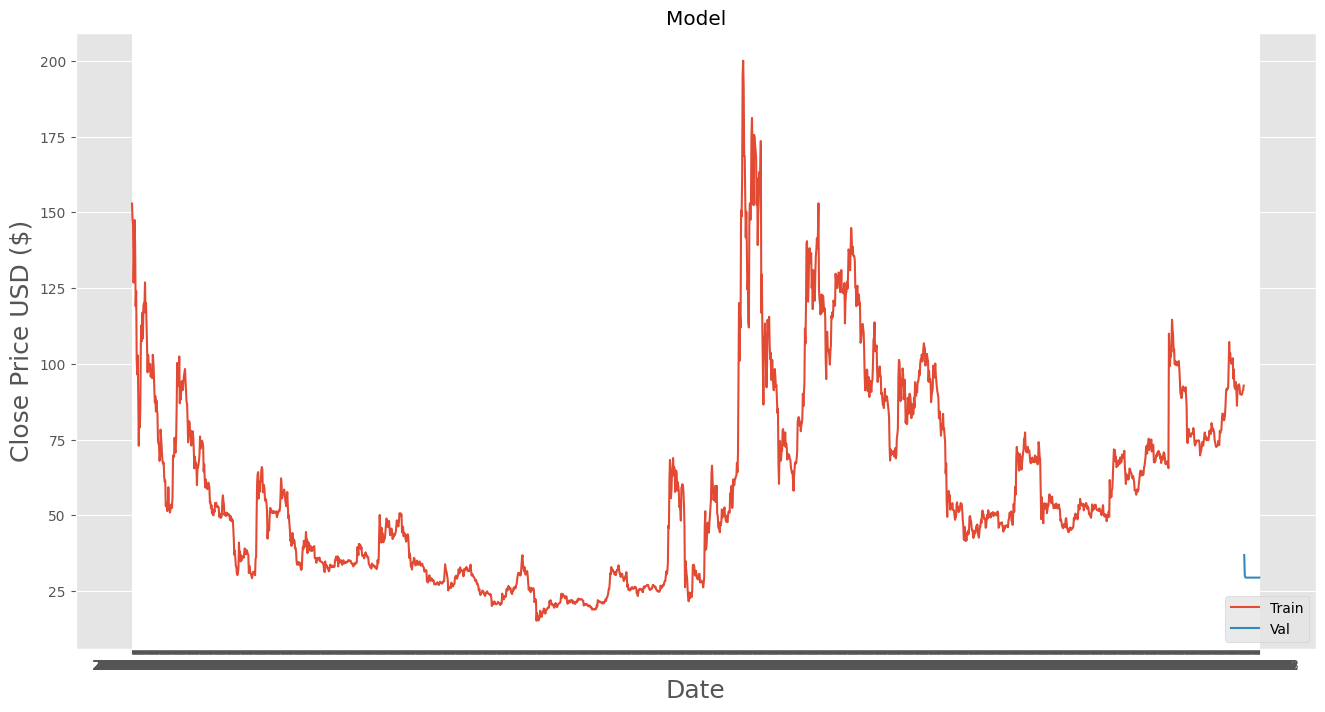

In [223]:
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()